#Projet BIG Data M2
## REALISE PAR:
- Abdelkader Nadir DEBBAGH
- Bouteyna LADAYCIA
- Amir SABA

# Introduction

Dans ce projet, nous allons aborder les différents concepts big data ainsi que les approches perméttant de pallier aux problèmes de mémoire et de calcul vus en cours.

Nous prenons comme cas d'étude l'algorithme KMeans dont nous implémenterons une version séquentielle tout d'abord en utilisant python, puis soulèverons le problème de cet algorithme sur le concept drift.

Nous montrons alors comment KMeans Streaming permet de s'adapter à un Concept Drift.

Nous implémentons ensuite des versions distribuées Apache Beam de KMeans, KMeans Séquentiel, ainsi que KMeans Streaming.

Notons également que nous proposons des versions memory efficient du calcul de l'accuracy ainsi que la NMI (Normalized Mutual Information) dans le cas où les labels prennent trop de mémoire et sont stockés dans des fichiers.

Nous vérifions alors la qualité et la correctitude des résultats données par nos implémentations en nous basant sur un jeu de données synthétiques générées aléatoirement.

In [ ]:
import warnings
warnings.filterwarnings("ignore") 

# A. Implémentation de k-means séquentiel (Python)

Dans cette partie, nous proposons une implémentation de KMeans Séquentiel. Cette version ne sera ni distribuée, ni parallélisée, et se basera sur les générateurs afin de permettre la récupération d'un flux d'informations depuis un fichier de très grande taille en le lisant ligne par ligne.

Nous proposons également des implémentations memory efficient de l'accuracy ainsi que la NMI en adoptant un calcul incrémental de celles-ci en lisant des labels ligne par ligne depuis des fichiers.

## Génération des Données

Dans un premier temps, il est nécessaire d'avoir en main des données qui seront pris comme entrées de nos algorithmes. Ceci permettra de tester le bon fonctionnement des implémentations et de visualiser le résultat.

Pour cela, nous générons des données bidimensionnelles composées de 200 observations réparties en deux clusters :
- Le premier ayant pour centre (5, 5)
- Et le deuxième étant centré en (10, 10)

In [ ]:
from sklearn.datasets import make_blobs
data_X, data_y = make_blobs(n_samples=200, centers=[(5, 5), (10, 10)], n_features=2, random_state=0)
print(data_X.shape)

(200, 2)


In [ ]:
import matplotlib.pyplot as plt

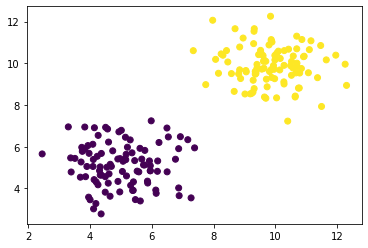

In [ ]:
plt.scatter(data_X[:, 0], data_X[:, 1], c = data_y)
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame({"X1": data_X[:, 0], "X2": data_X[:, 1], "y": data_y})

In [ ]:
df.head()

,X1,X2,y
0,7.269755,3.545634,0
1,10.274516,9.109085,1
2,5.066517,5.302472,0
3,3.774564,5.844363,0
4,4.196590,4.310450,0


Nous enregistrons alors les données dans un fichier qui sera utilisé pour simuler un flux de données temps réel.

In [ ]:
df.to_csv("features_2_100.csv")

## Lecture Memory Efficient par Batch depuis un Fichier

Nous proposons alors la fonction `read_csv_generator` qui permet de créer un générateur qui lit les lignes d'un fichier une par une et fait du batching pour renvoyer des batchs de taille choisie.

Nous ajoutons également les paramètres `with_header`, `with_index` et `skip`; qui permettent :
- `with_header` : ignorer la première ligne du fichier (s'il contient un header)
- `with_index` : ignorer la première colonne du fichier si celle-ci est présente (elle représente l'index)
- `skip` : permet de spécifier le nombre de lignes à ignorer (dans le cas où le header n'est pas que sur une ligne)

Le fichier lu est supposé sous un format csv où les premières colonnes (autres que l'index), représentent les coordonnées (X), et la dernière colonne représente le label (Y). Notons que le label pourrait être facilement omis et devrait l'être puisqu'on travaille sur une tâche non supervisée, mais nous le laissons puisqu'il est présent dans la plupart des datasets d'apprentissage.  

In [ ]:
import numpy as np
def read_csv_generator(filename, batch_size = 1, with_header = True, with_index = True, skip = 0):
  count = 0
  with open(filename) as f:
    if with_header:
      f.readline()
    batch_X = []
    batch_y = []
    while True:
      line = f.readline().strip()
      if not line:
          break
      cols = line.split(",")
      if with_index:
        cols = cols[1:]
      count+= 1
      batch_X.append(np.array([float(x) for x in cols[:-1]]))
      batch_y.append(int(cols[-1]))
      if count % batch_size == 0:
        batch_X = np.stack(batch_X)
        batch_y = np.array(batch_y)
        yield batch_X, batch_y
        batch_X = []
        batch_y = []

In [ ]:
for A, b in read_csv_generator("features_2_100.csv", batch_size = 10):
  print(A.shape, b.shape)

(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)
(10, 2) (10,)


## Implémentation Memory Efficient de Sequential KMeans

In [ ]:
def KMeansSeq(file_flux, nb_centers, distance_function = "euclidean"):
  if distance_function == "euclidean":
    distance_function = lambda x, y: ((x - y)**2).sum()
  ## Initialisation
  centers = [] # µk
  effectifs = [] # nk
  i = 0
  data_gen_flow = read_csv_generator(file_flux, batch_size = 1)

  with open("results.csv", "w") as out:
    # initialisation des centroïdes par les nb_centers premiers centres
    for X, _ in data_gen_flow: # lecture à partir du générateur
      i += 1
      centers.append(X)
      effectifs.append(1)
      out.writelines([",".join([str(x) for x in X[0, :]]) + f",{i - 1}\n"])

      if i == nb_centers:
        break
    
    ## suite de la lecture à partir du générateur => boucle principale du stream
    for X, _ in data_gen_flow:
      min_dist = np.inf
      min_idx = -1

      # calculer la distance à chacun des centres et trouver le plus proche
      for cid, center in enumerate(centers):
        center_dist = distance_function(center, X)
        if center_dist < min_dist:
          min_idx = cid
          min_dist = center_dist


      # mettre à jour le centre le plus proche
      centers[min_idx] += (X - centers[min_idx]) / (effectifs[min_idx] + 1)
      # mettre à jour l'effectif du centre le plus proche
      effectifs[min_idx] += 1
      # enregistrer le résultat du classement dans un fichier (ne monopolise pas la RAM)
      out.writelines([",".join([str(x) for x in X[0, :]]) + f",{min_idx}\n"])
  
  # retourner les centroïdes et les effectifs par cluster
  return {"centers" : np.array(centers)[:, 0, :], "counts" : effectifs}

In [ ]:
ret = KMeansSeq("features_2_100.csv", 2)

In [ ]:
cents = np.stack(ret["centers"])

In [ ]:
cents.shape

(2, 2)

Nous affichons alors les centroïdes retrouvés par KMeans Séquentiel ainsi que les points en question afin de valider le bon fonctionnement de notre implémentation.

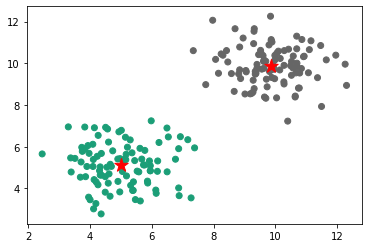

In [ ]:
plt.scatter(data_X[:, 0], data_X[:, 1], c = data_y, cmap = "Dark2")
plt.scatter(cents[:, 0], cents[:, 1], c = "red", s = 200, marker = "*")

plt.show()

## Implémentation "Memory Efficient" de l'Accuracy

In [ ]:
def incremental_accuracy_calculation(file_flux, file_res):
  acc = 0.0
  count = 0
  res_generator = read_csv_generator(file_res, with_header = False, with_index = False) 
  for X, y in read_csv_generator(file_flux, batch_size = 1):
    try:
      _, y_pred = next(res_generator)
      acc = (count * acc + int(y == y_pred)) / (count + 1)

    except StopIteration:
      print("Reached end of file, can't execute next anymore")
      break

    count += 1
  
  return acc

In [ ]:
incremental_accuracy_calculation("features_2_100.csv", "results.csv")

1.0

## Implémentation "Memory Efficient" de la NMI

Dans ce qui suit, nous proposons une implémentation de la NMI permettant le calcul incrémental de celle-ci à partir de deux flux de labels. Ceci permet alors de calculer la NMI dans le cas où l'ensemble des labels ne tient pas en mémoire RAM.

In [ ]:
def incremental_nmi_calculation(file_flux, file_res):
  nmi = 0.0
  real_entropy = 0.0
  pred_entropy = 0.0

  count = 0
  res_generator = read_csv_generator(file_res, with_header = False, with_index = False) # générateur pour les labels prédits
  real_counts_dict = dict() # nombre d'éléments par vraie classe

  pred_counts_dict = dict() # nombre d'éléments par cluster construit

  nclass_in_cluster_dict = dict() # nombre d'éléments de chaque classe par cluster
  for X, y in read_csv_generator(file_flux, batch_size = 1):
    # incrémentation du compteur du nombre éléments par vraie classe
    if y[0] not in real_counts_dict:
      real_counts_dict[y[0]] = 1
    else:
      real_counts_dict[y[0]] += 1

    try:
      _, y_pred = next(res_generator)

      # incrémentation du compteur du nombre éléments par cluster construit
      if y_pred[0] not in pred_counts_dict:
        pred_counts_dict[y[0]] = 1
      else:
        pred_counts_dict[y[0]] += 1

      # incrémentation du compteur du nombre d'éléments de la classe y dans le cluster y_pred
      # dictionnaire à deux niveaux
      # {
      #   0 : {0:count1, 1:count2}, 
      #   1 : {0:count3, 1:count4}
      # }
      if y_pred[0] not in nclass_in_cluster_dict:
        nclass_in_cluster_dict[y_pred[0]] = dict()
      if y[0] not in nclass_in_cluster_dict[y_pred[0]]:
        nclass_in_cluster_dict[y_pred[0]][y[0]] = 1
      else:
        nclass_in_cluster_dict[y_pred[0]][y[0]] += 1
      
    except StopIteration: # dans le cas où il n'ya pas le même nombre d'éléments entre les labels prédits et réels => ERREUR
      print("Reached end of file, can't execute next anymore")
      break
    count += 1 # count total du nombre d'éléments
  
  # Calcul de l'entropie des classes réelles H(Y) =  SOMME( - P(Y = y) * log2(P(Y = y))  )
  for k in real_counts_dict:
    p = real_counts_dict[k] / count
    real_entropy -= p * np.log2(p)

  # Calcul de l'entropie des clusters H(Y_PRED) = SOMME( - P(Y_PRED = y) * log2(P(Y_PRED = y))  )
  for k in pred_counts_dict:
    p = pred_counts_dict[k] / count
    pred_entropy -= p * np.log2(p)

  # calcul de l'entropie conditionnelle H(Y | Y_PRED)
  cond_entropy = dict()
  for k in pred_counts_dict:
    ss = 0
    for a in nclass_in_cluster_dict[k]:
      p = nclass_in_cluster_dict[k][a] / pred_counts_dict[k]
      ss += p * np.log2(p)
    cond_entropy[k] = - (pred_counts_dict[k] / count) * ss

  total_cond_entropy = 0
  for k in cond_entropy:
    total_cond_entropy += cond_entropy[k]

  mutual_info = real_entropy - total_cond_entropy # Calcul de l'information mutuelle  I(Y, Y_PRED) = H(Y) - H(Y | Y_PRED)

  # Calcul de la NMI = 2 * I(Y, Y_PRED) / (H(Y) + H(Y_PRED))
  nmi = 2 * mutual_info / (real_entropy + pred_entropy)
  return nmi

In [ ]:
incremental_nmi_calculation("features_2_100.csv", "results.csv")

1.0

# B. Implémentation d’une version streaming de k-means (Python)

Dans cette partir nous allons tout d'abord générer des données avec un **CONCEPT DRIFT**, où :
- Les 200 premiers points sont issus d'une distribution avec des centres (5,5) et (10,10)
- Les 200 derniers points sont issus d'une distribution avec des centres (5,10) et (10, 5)

In [ ]:
from sklearn.datasets import make_blobs
data_X_first, data_y_first = make_blobs(n_samples=200, centers=[(5, 5), (10, 10)], n_features=2, random_state=0)
data_X_drift, data_y_drift = make_blobs(n_samples=200, centers=[(5, 10), (10, 5)], n_features=2, random_state=0)

data_X = np.concatenate([data_X_first, data_X_drift])
data_y = np.concatenate([data_y_first, data_y_drift])

In [ ]:
data_X.shape

(400, 2)

In [ ]:
import matplotlib.pyplot as plt

Dans la figure suivante, les triangles représentent la distribution initiale, et les croix la nouvelle distribution après concept drift

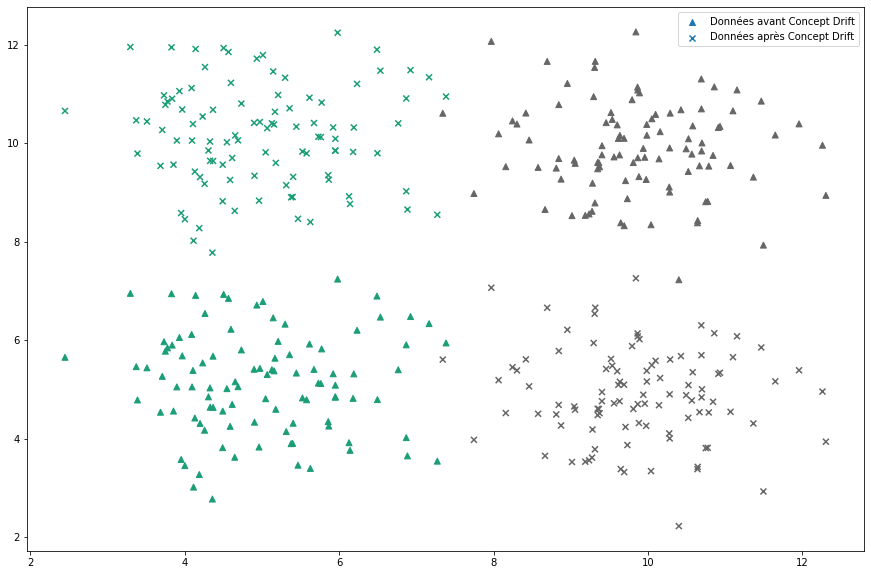

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(data_X[:200, 0], data_X[:200, 1], marker = "^", c = data_y[:200], cmap = "Dark2", label = "Données avant Concept Drift")
plt.scatter(data_X[200:, 0], data_X[200:, 1], marker = "x", c = data_y[200:], cmap = "Dark2", label = "Données après Concept Drift")

plt.legend()
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame({"X1": data_X[:, 0], "X2": data_X[:, 1], "y": data_y})

In [ ]:
df.head()

,X1,X2,y
0,7.269755,3.545634,0
1,10.274516,9.109085,1
2,5.066517,5.302472,0
3,3.774564,5.844363,0
4,4.196590,4.310450,0


In [ ]:
df.to_csv("features_concept_drift.csv")

## Limitation de KMeans Séquentiel

Dans cette partie, nous allons relever les limitations de KMeans Séquentiel dans le cas d'un concept Drift et allons justifier l'utilisation d'une version Streaming de KMeans dans ce cas là.

In [ ]:
ret = KMeansSeq("features_concept_drift.csv", 2)
cents = np.stack(ret["centers"])

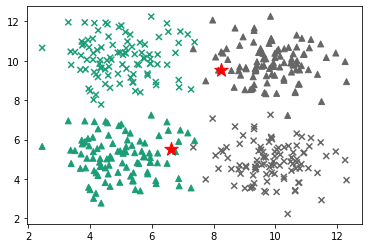

In [ ]:
plt.scatter(data_X[:200, 0], data_X[:200, 1], marker = "^", c = data_y[:200], cmap = "Dark2")
plt.scatter(data_X[200:, 0], data_X[200:, 1], marker = "x", c = data_y[200:], cmap = "Dark2")

plt.scatter(cents[:, 0], cents[:, 1], c = "red", marker = "*", s = 200)

plt.show()

Nous remarquons comment les centroïdes ne sont pas bien placés à la fin du stream. En effet, ceux-ci devraient être en (5, 10) et (10, 5), alors qu'ils sont à mi chemin entre les anciens et les nouveaux centroïdes.

Ceci est causé par le fait que l'information sur les premiers centroïdes est gardée et donc n'est pas oubliée au fur et à mesure du temps. Celle-ci étant devenue obsolète, elle fausse donc les résultats.

## Solution : KMeans Streaming
Une solution au problème de Concept Drift non modélisé par KMeans Séquentiel, est l'utilisation de KMeans Streaming où une liste de *T* batchs est gardée en mémoire et un KMeans pondéré est effectué de sorte à donner moins d'importance aux anciens batchs.

Dans cette section, nous procédons à son implémentation.
Tout d'abord, nous créons une structure de données "LimitedBuffer", qui permettra d'implémenter la logique de la liste limitée.

In [ ]:
class LimitedBuffer():
  def __init__(self, MAX_SIZE):
    self.buffer = []
    self.MAX_SIZE = MAX_SIZE
    
  def add(self, element):
    if len(self.buffer) < self.MAX_SIZE:
      self.buffer.append(element)
    else:
      self.buffer = self.buffer[1:]
      self.buffer.append(element)
  
  def pop_recent(self):
    if len(self.buffer) != 0:
      to_return = self.buffer[-1]
      self.buffer = self.buffer[:-1]
      return to_return
    else:
      print(f"ERROR: index out of range, it doesn't exist in the buffer : (buffer size = {len(self.buffer)})")
      exit(-2)

  def pop_old(self):
    if len(self.buffer) != 0:
      to_return = self.buffer[0]
      self.buffer = self.buffer[1:]
      return to_return
    else:
      print(f"ERROR: index out of range, it doesn't exist in the buffer : (buffer size = {len(self.buffer)})")
      exit(-2)

  def pop_by_index(self, idx):
    if idx < len(self.buffer):
      to_return = self.buffer[idx]
      self.buffer = self.buffer[0:idx] + self.buffer[idx+1:]
      return to_return
    else:
      print(f"ERROR: index out of range, it doesn't exist in the buffer : (buffer size = {len(self.buffer)}, and index = {idx})")
      exit(-2)
  def get(self, idx):
    if idx < len(self.buffer):
      return self.buffer(idx)
    else:
      print(f"ERROR: index out of range, it doesn't exist in the buffer : (buffer size = {len(self.buffer)}, and index = {idx})")
      exit(-2)

  def get_data(self):
    return np.concatenate(self.buffer)

  def get_number_elements(self):
    return len(self.buffer)

  def get_batches_weights(self, r):
    weights = []
    for i in range(len(self.buffer) - 1, -1, -1):
      for b in range(len(self.buffer[i])):
        weights.append(r**i)
    return weights

Nous passons maintenant à l'implémentation de KMeans Streaming :

In [ ]:
from sklearn.cluster import KMeans
class StreamingKMeans():
  def __init__(self, nb_centers, T, r):
    self.buffer = LimitedBuffer(T)
    self.T = T
    self.r = r
    self.nb_centers = nb_centers

  def process(self, batch0, partition = None):
    # si pas de partition, initialiser les centres aléatoirement
    if partition is None:
      km = KMeans(n_clusters = self.nb_centers)
    else: # sinon, les initialiser avec une moyenne de la liste X par partition
      init_centers = np.stack([self.buffer.get_data()[partition == i].mean(axis = 0) for i in range(self.nb_centers)])
      km = KMeans(n_clusters = self.nb_centers, init = init_centers)
    
    self.buffer.add(batch0)
    # générer les poids des points
    poids = self.buffer.get_batches_weights(self.r)
    # exécuter KMeans avec des poids par batch
    km.fit(self.buffer.get_data(), sample_weight = np.array(poids))
    return km.cluster_centers_, km.labels_

In [ ]:
# CODE DE TEST
#stream_kmeans = StreamingKMeans(nb_centers = 2, T = 15, r = 0.1)
#C, P = stream_kmeans.process(X)
#print(P)
#C, P = stream_kmeans.process(X, P)
#print(P)

Dans la cellule qui suit, nous exécutons l'algorithme Streaming KMeans avec T = 3 et r = 0.1 sur notre dataset simulant un concept drift.

Nous affichons à chaque batch les points du buffer (batch en mémoire), ainsi que les centroides calculés. Pendant l'exécution, il est possible de visualiser l'animation des points au fil du temps. 

Nous affichons également l'ensemble des points ainsi que les centroïdes, montrant ainsi l'évolution des centroïdes et leur déplacement entre la première distribution de clusters et la deuxième.

Nous avons remarqué en testant plusieurs valeurs de T, que :
- Pour de petites valeurs nous avons une transition assez rapide, et une détection quasi instantanée d'un changement de concept, cependant des valeurs petites de T impliquent une haute sensibilité au bruit.
- Pour les grandes valeurs de T, nous remarquons que le modèle peut peiner à détecter les concept drift, et les centroïdes peuvent se trouver bloqués en certaines positions, il faudra alors ajuster la valuer de r afin de permettre un oubli plus prononcé des anciens batch.

In [ ]:
!mkdir gif
!mkdir gif/gif_all
!mkdir gif/gif_mem_list

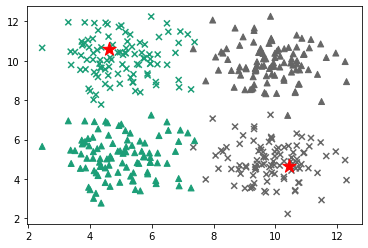

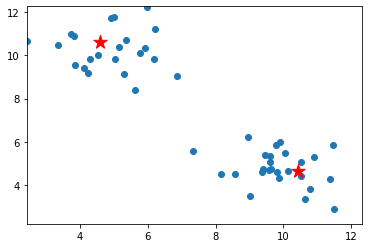

25

In [ ]:
stream_kmeans = StreamingKMeans(nb_centers = 2, T = 3, r = 0.1)
C = None
P = None
calc = 0
from IPython.display import clear_output
import time

for X, y in read_csv_generator("features_concept_drift.csv", batch_size = 16, with_header = True, with_index = True, skip = 0):
  time.sleep(0.5)
  clear_output(wait=True)
  C, P = stream_kmeans.process(X, P)
  plt.scatter(data_X[:200, 0], data_X[:200, 1], marker = "^", c = data_y[:200], cmap = "Dark2")
  plt.scatter(data_X[200:, 0], data_X[200:, 1], marker = "x", c = data_y[200:], cmap = "Dark2")
  plt.scatter(C[:, 0], C[:, 1], c = "red", marker = "*", s = 200)
  
  plt.savefig("gif/gif_all" + f"/img{calc}")
  plt.show()
  
  plt.scatter(stream_kmeans.buffer.get_data()[:, 0], stream_kmeans.buffer.get_data()[:, 1])
  plt.scatter(C[:, 0], C[:, 1], c = "red", marker = "*", s = 200)
  plt.xlim((np.min(data_X[:, 0]), np.max(data_X[:, 0])))
  plt.ylim((np.min(data_X[:, 1]), np.max(data_X[:, 1])))
  plt.savefig("gif/gif_mem_list" + f"/img{calc}")
  plt.show()
  
  
  calc += 1
calc

Nous sauvegardons les images de plots intermédiaires obtenues puis utilisons un outil en ligne afin de construire un gif illustrant l'évolution de l'algorithme sur les données et son adaptation au concept drift.

In [ ]:
!zip -r /content/gifs.zip /content/gif/

In [ ]:
from google.colab import files
files.download("/content/gifs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Le premier gif (suivant), montre l'évolution des centroïdes sur l'ensemble des données montrant ainsi l'adaptation au concept drift :

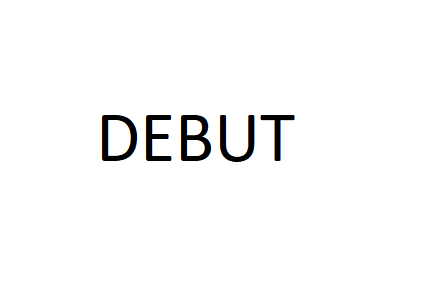

In [ ]:
from IPython.display import Image
Image(open('all.gif','rb').read())

Le second gif quant à lui montre l'évolution des centroïdes selon les batchs gardés en mémoire (avec **T=3** et **r = 0.1**), on voit alors clairement comment le changement de concept se fait et l'effet de l'oubli des anciens batch sur les résultats : 

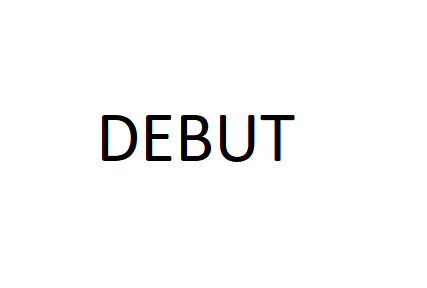

In [ ]:
Image(open('in_mem.gif','rb').read())

## **NOTONS QUE LE CODE PRECEDENT EST ANIME, ET IL EST DONC PLUS INTERESSANT D'EXECUTER POUR VOIR L'EVOLUTION DES CENTROIDES. NOUS ATTACHONS TOUT DE MEME DEUX GIFS MONTRANT L'EXECUTION.**

# C. Implémentation de k-means distribué (Apache Beam)

In [ ]:
from random import randrange
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from sklearn.datasets import make_blobs

In [ ]:
######## Paramètres pipeline
NB_ITERATION = 10
options = PipelineOptions()
n_cluster=2

class Create_tuple(beam.DoFn):
    def process(self, element):
        # Returns a list of tuples containing the  key (the number of the cluster) and the element
        return [(randrange(n_cluster), element)]

def assign_cluster(point, centroids):
  min_dist = np.inf # initialisez la distance à l'infini 
  num_clust = None # initialisez le num cluster à Null
  for centers in centroids: # parcourez tout les centres des clusters
    dist = distance_function(np.array(point[1]), np.array(centers[1])) # calcul de la distance entre le centre et le point
    if dist < min_dist: # vérification de la distance
      min_dist = dist # mettre à jour la distance minimal 
      num_clust = centers[0] # garder la trace du numero de cluster
  yield (num_clust, point[1]) # retourner le numero du cluster et les coordonnées du point

def perform_mean(values):
  mean=np.mean(list(values), axis = 0) # Calcul de la moyenne des vecteurs (Pour la phase calcul des centres)
  return mean
def print_and_forward(x):
  print(x)
  return x
distance_function = lambda x, y: np.linalg.norm(x-y) # Fonction qui calcul la distance entre 2 vecteurs

In [ ]:
X, y = make_blobs(n_samples=200, centers=[(5, 5), (10, 10)], n_features=n_cluster, random_state=0) # Génération des donnés 

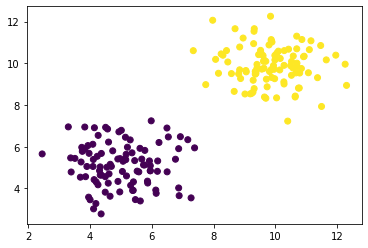

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

In [ ]:
with beam.Pipeline(options=options) as pipeline: # Création de la pipeline
  data = ( 
    pipeline
    |beam.Create(X)  # Création d'une Pcollection pour le jeu de donnée crée.
    |beam.ParDo(Create_tuple()) # Transformer la Pcollection en tuple (num_cluster, coordonnées du point)
  )
  
  for i in range(NB_ITERATION): # Boucle pour itérer NB_ITERATION fois le calcul des centroids / assignation des points à leurs clusters
    centroids = (
        # Calcul des centroids en utilisant une moyenne sur le résultat du combineparkey(soit sur les points du même cluster)
        data
        | f"calculate centroids {i}" >> beam.CombinePerKey(perform_mean)

    )
    
    clusters =  (
      # assignation des points à leurs clusters en calculant la distance de chaque points avec les centroids.
      data 
      | f"assign to clusters {i}" >> beam.ParDo(assign_cluster, beam.pvalue.AsIter(centroids))
    )

    data = clusters # réinjection de la partition

  
  (
      centroids 
      |"print Centroids Values " >> beam.Map(print_and_forward) # Print centroids 
  )
  output= ( 
      # Write kmeans results on a file
        clusters
        |beam.io.WriteToText("./result.txt")
         )

(0, array([4.65898859, 5.61300424]))
(1, array([10.43100986,  9.64601766]))


Nous remarquons alors que les centroïdes retrouvés se rapprochent bien de la réalité (5, 5) et (10, 10); prouvant ainsi le bon fonctionnement de notre implémentation.

Notons que cette implémentation permet un calcul parallèle des centroïdes grâce au CombinePerKey; eelle-ci est donc scalable.

# D. Implémentation de k-means séquentiel distribuée (Apache Beam)

Dans cette partie, nous implémentons une version séquentielle de KMeans en se basant sur les states Apache Beam.

In [ ]:
!pip install apache-beam

In [ ]:
import apache_beam as beam
from apache_beam.transforms.userstate import BagStateSpec

class StateSeqKMeans(beam.DoFn):
  centers = BagStateSpec(name='centers', coder=beam.coders.PickleCoder())
  counts = BagStateSpec(name='counts', coder=beam.coders.PickleCoder())
  def __init__(self, nb_centers):
    self.nb_centers = nb_centers

  def get_closest_centroid(self, centroids, x):
    min_dist = np.inf
    min_idx = -1
    for i, c in enumerate(centroids):
      d = ((x- c)**2).sum()
      if d < min_dist:
        min_dist = d
        min_idx = i
    return min_idx

  def process(self, element, centers=beam.DoFn.StateParam(centers), counts=beam.DoFn.StateParam(counts)):
    key, value = element
    closest_cluster_id = -1
    # CAS OU LES ETATS SONT VIDES (PREMIER ELEMENT DU STREAM)
    if list(centers.read()) == []:
      centers.add([value]) # ajouter le centroïde
      counts.add([1]) # n = 1
      closest_cluster_id = 0

    # CAS OU LES ETATS NE SONT PAS VIDES, MAIS IL N Y A PAS ENCORE ASSEZ DE CENTRES
    # NOTONS QUE CECI PERMET D'INITIALISER KMeans SEQUENTIEL AVEC LES NB_CENTERS PREMIERES OBSERVATIONS
    elif len(list(counts.read())[0]) < self.nb_centers:
      all_centers = list(centers.read())[0] # récupérer la liste des centroïdes
      all_centers.append(value) # ajouter le point comme centroïde
      centers.clear() # effacer la variable
      centers.add(all_centers) # remplacer par la nouvelle liste avec le nouveau centroïde

      # incrémentation de n (count)
      n = list(counts.read())[0] # récupérer la liste des n
      counts.clear() # effacer 
      n.append(1)
      counts.add(n)
      closest_cluster_id = len(n)
    # CAS GENERAL
    else:
      all_centers = list(centers.read())[0]
      closest_cluster_id = self.get_closest_centroid(all_centers, value)
      n = list(counts.read())[0]
      all_centers[closest_cluster_id] += (value - all_centers[closest_cluster_id]) / (n[closest_cluster_id] + 1)
      n[closest_cluster_id] += 1
      counts.clear()
      counts.add(n)

      centers.clear()
      centers.add(all_centers)
    yield list(centers.read())[0], closest_cluster_id

In [ ]:
def print_and_forward(x):
  print(x)
  return x
with beam.Pipeline() as pipeline:
  data = (
    pipeline
    | "Create" >> beam.Create(
      [(0, x) for x in data_X]
    )
  )

  result = (data
  | "Update state" >> beam.ParDo(StateSeqKMeans(2))
  | "Print" >> beam.Map(print_and_forward)
  | "Write To File" >> beam.io.WriteToText("out.o")
  )

([array([7.26975462, 3.54563433])], 0)
([array([7.26975462, 3.54563433]), array([10.27451636,  9.10908492])], 2)
([array([6.16813592, 4.42405311]), array([10.27451636,  9.10908492])], 0)
([array([5.37027878, 4.89748973]), array([10.27451636,  9.10908492])], 0)
([array([5.07685667, 4.75072986]), array([10.27451636,  9.10908492])], 0)
([array([5.25150302, 4.77031244]), array([10.27451636,  9.10908492])], 0)
([array([4.92520748, 5.13372293]), array([10.27451636,  9.10908492])], 0)
([array([4.92520748, 5.13372293]), array([9.95491141, 9.63289439])], 1)
([array([4.92520748, 5.13372293]), array([9.98281779, 9.20302456])], 1)
([array([5.15486059, 5.32452805]), array([9.98281779, 9.20302456])], 0)
([array([5.15486059, 5.32452805]), array([10.15956788,  9.72772997])], 1)
([array([5.15486059, 5.32452805]), array([9.89618325, 9.71972553])], 1)
([array([5.15486059, 5.32452805]), array([9.89082776, 9.95591984])], 1)
([array([5.0392635, 5.3513682]), array([9.89082776, 9.95591984])], 0)
([array([5.03

L'avantage d'avoir une clé unique est d'abord que l'espace de stockage de l'état se trouve réduit puisqu'on dispose d'un seul état global. Cependant, en termes de parallélisation, il se trouve que l'accès à cet état se fait en concurrence, et rend alors la parallélisation impossible.

Cependant, une parallélisation ne serait pas possible, puisque dans KMeans Séquentiel, les données arrivent une à une, et il est donc nécessaire d'avoir un état global.

Nous remarquons sur la sortie de l'algorithme, que sur les premières itérations, KMeans Séquentiel retrouve bien les centroïdes, mais peine à s'adapter lors du Concept Drift. Ceci montre alors le bon fonctionnement de l'implémentation, mais pointe et confirme la limitation de KMeans Séquentiel sur des données dont la distribution change.

# E. Implémentation d’une version streaming et distribuée de k-means (Apache Beam)

## Fonction de Batching

In [ ]:
class PerformBatching(beam.DoFn):
  batch = BagStateSpec(name='batch', coder=beam.coders.PickleCoder())
  def __init__(self, batch_size):
    self.batch_size = batch_size

  def process(self, element, batch=beam.DoFn.StateParam(batch)):
    key, value = element
    b = list(batch.read())
    if len(b) != 0:
      b = b[0]
    if len(b) != self.batch_size:
      b.append(value)
      batch.clear()
      batch.add(b)
      
    if len(b) == self.batch_size:
      yield (0, b)
      batch.clear()

## Fonction de traitement de batch

In [ ]:
import apache_beam as beam
from apache_beam.transforms.userstate import BagStateSpec
from sklearn.cluster import KMeans
# si pas de partition, initialiser les centres aléatoirement
  

class DistributedStreamingKMeans(beam.DoFn):
  centers = BagStateSpec(name='centers', coder=beam.coders.PickleCoder())
  last_batches = BagStateSpec(name='last_batches', coder=beam.coders.PickleCoder())
  def __init__(self, nb_centers, T, r):
    self.nb_centers = nb_centers
    self.T = T
    self.r = r

  def get_batches_weights(self, buffer):
    weights = []
    if buffer == []:
      return []
    else:
      buffer = buffer[0]

    for i in range(len(buffer) - 1, -1, -1):
      for b in range(len(buffer[i])):
        weights.append(self.r**i)
    return weights

  def process(self, element, centers=beam.DoFn.StateParam(centers), last_batches=beam.DoFn.StateParam(last_batches)):
    key, value = element
    centers_list = list(centers.read())
    if centers_list == []:
      km = KMeans(n_clusters = self.nb_centers)
    else: # sinon, les initialiser avec une moyenne de la liste X par partition
      init_centers = np.stack(centers_list[0])
      km = KMeans(n_clusters = self.nb_centers, init = init_centers)
    

    lim_b = list(last_batches.read())
    if lim_b != []:
      lim_b = lim_b[0]
    if len(lim_b) < self.T:
      lim_b.append(value)
    else:
      lim_b.append(value)
      lim_b = lim_b[1:]
    last_batches.clear()
    last_batches.add(lim_b)
    
    # générer les poids des points
    poids = self.get_batches_weights(list(last_batches.read()))
    # exécuter KMeans avec des poids par batch
    km.fit(np.concatenate(lim_b), sample_weight = np.array(poids))
    centers.clear()
    centers.add(km.cluster_centers_)
    yield km.cluster_centers_

## Exécution du Stream
Dans cette partie nous générons un stream de données à partir des données générées au début du notebook (données avec concept drift)

In [ ]:
with beam.Pipeline() as pipeline:
  data = (
    pipeline
    | "Create" >> beam.Create(
      [(0, x) for x in data_X]
    )
  )

  result = (data
  | "Effectuer du batching sur le stream" >> beam.ParDo(PerformBatching(4))
  #| "prin value" >> beam.Map(print_and_forward)

  | "map count" >> beam.ParDo(DistributedStreamingKMeans(2, 4, 0.5))
  | "print value" >> beam.Map(print_and_forward)
  | "Write To File" >> beam.io.WriteToText("out.o")
  )

[[ 5.37027878  4.89748973]
 [10.27451636  9.10908492]]
[[4.77685038 5.21246734]
 [9.84837642 9.80749754]]
[[5.31713618 5.59920316]
 [9.85530021 9.78358988]]
[[ 4.90302103  5.57636355]
 [10.04072801 10.01197683]]
[[ 4.56290646  5.37333481]
 [10.1139047   9.79664014]]
[[ 5.66054126  5.37481583]
 [10.01470833  9.6248015 ]]
[[ 5.0794432   5.81327541]
 [10.11947349  9.95711113]]
[[ 5.06999762  5.30505188]
 [10.11390146  9.92747   ]]
[[ 5.54374215  4.89527306]
 [ 9.99833263 10.1576328 ]]
[[5.00559723 5.04539442]
 [9.43164712 9.73086892]]
[[4.52038954 5.43515125]
 [9.40660721 9.78061979]]
[[4.44958637 5.49118548]
 [9.97759493 9.7317048 ]]
[[4.56068917 4.93216021]
 [9.72295935 9.66947907]]
[[ 4.79585284  5.28557149]
 [10.22567619 10.56261441]]
[[5.58899322 5.96991492]
 [9.8975935  9.78491881]]
[[ 4.99448692  5.52846345]
 [ 9.50714515 10.45495573]]
[[5.31409359 4.29611234]
 [9.70858326 9.63120741]]
[[ 4.74313237  3.95035942]
 [10.0793168   9.95678412]]
[[ 4.51417969  4.18697297]
 [10.40017591  

Nous rappelons que dans les données que nous prenons comme base (données streamées). Nous avons généré un stream de 400 observations bidimensionnelles. Celles-ci représentent des points appartenant à deux classes. Nous introduisons un concept drift au bout de la 200e observation. En effet, pour les 200 premières observations, nous générons celles-ci de sorte à avoir des centroïdes (5, 5) et (10, 10).
Puis, basculons sur les centroïdes (5, 10) et (10, 5) sur les 200 dernières observations. Permettant ainsi d'évaluer la robustesse de l'algorithme.

En analysant les sorties de l'algorithme, nous remarquons que dans les premiers batchs (200 premières observations), les centroïdes retrouvés par l'algorithme sont bien les bons. En effet, celui-ci retrouve bien (5, 5) ainsi que (10, 10).

Et puisque nous avons introduit un concept drift dans les données, leur distribution change au fil du temps, et passe à des centroïdes en (10, 5) et (5, 10) sur les 200 dernières observations; qui sont bien retrouvés par l'algorithme.

Ceci montre alors la correctitude de l'implémentation que nous avons proposé.

# Conclusion

Dans ce projet, nous avons pu tester des approches permettant de traiter des problèmes liées au grand volume de données (problématiques big data). Nous avons d'abord eu recours aux générateurs afin de charger des données et les batcher, puis les traiter séquentiellement sans occuper beaucoup de mémoire.

Nous avons ensuite utilisé les générateurs afin d'implémenter une version non distribuée de KMeans séquentiel, puis KMeans streaming. Nous avons également utilisé la puissance des générateurs pour concevoir puis implémenter une version memory efficient du calcul d'accuracy (dans le cas où les labels ne tiennent pas en mémoire), ainsi que de la NMI (Normalized Mutual Information); ceci est fait par un calcul incrémental de celles-ci selon leurs formules.

Par la suite, nous sommes passé à una autre méthode permettant d'atténuer les pénalités liées à l'aspect big data. La méthode consiste à distribuer le calcul ainsi que les données sur plusieurs machines afin d'accélérer un calcul parallélisable. Nous avons alors implémenté l'algorithme KMeans Offline Distribué.

Ensuite, nous avons procédé à l'implémentation de KMeans Séquentiel distribué, où nous avons vu l'importance de l'API de gestion d'état (state) d'Apache Beam dans la syncronisation et la rétention de données intermédiaires.

Enfin, nous avons implémenté l'algorithme KMeans Streaming où nous avons implémenté une classe permettant de faire du Batching, ainsi qu'une deuxième permettant de traiter les batchs en question selon l'algorithme décrit en B.

Dans toutes les parties, nous avons veillé à vérifier la correctitude des résultats retournés par des graphiques graduels itératifs, ainsi que par la vérification des valeurs des centroïdes.

Notons que nous avons également introduit un concept drift afin de visualiser la puissance des version Séquentielle et Streaming de KMeans. Celui-ci a bien été détecté par les 2 implémentations Streaming et a donc induit un changement des centroïdes avec le temps.